In [1]:
import os,sys
import numpy as np
import scipy
from scipy import ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image
import random

@tf.function
def DataSet():
    
    normal_train = './train/NORMAL/'
    pneumonia_train = './train/PNEUMONIA/'
    
    normal_test = './test/NORMAL/'
    pneumonia_test = './test/PNEUMONIA/'
    
    img_normal_train = os.listdir(normal_train)
    img_pneumonia_train = os.listdir(pneumonia_train)
    
    img_normal_test = os.listdir(normal_test)
    img_pneumonia_test = os.listdir(pneumonia_test)
        
    X_train = np.empty((len(img_normal_train) + len(img_pneumonia_train), 100, 100, 3))
    Y_train = np.empty((len(img_normal_train) + len(img_pneumonia_train), ))
    count = 0
    for img_name in img_normal_train:
        
        img_path = normal_train + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_train[count] = img
        Y_train[count] = np.array(0)
        count+=1
        
    for img_name in img_pneumonia_train:

        img_path = pneumonia_train + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_train[count] = img
        Y_train[count] = np.array(1)
        count+=1
        
    X_test = np.empty((len(img_normal_test) + len(img_pneumonia_test), 100, 100, 3))
    Y_test = np.empty((len(img_normal_test) + len(img_pneumonia_test), ))
    count = 0
    for img_name in img_normal_test:

        img_path = normal_test + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_test[count] = img
        Y_test[count] = np.array(0)
        count+=1
        
    for img_name in img_pneumonia_test:
        
        img_path = pneumonia_test + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_test[count] = img
        Y_test[count] = np.array(1)
        count+=1
        
    index = [i for i in range(len(X_train))]
    random.shuffle(index)
    X_train = X_train[index]
    Y_train = Y_train[index]
    
    index = [i for i in range(len(X_test))]
    random.shuffle(index)
    X_test = X_test[index]    
    Y_test = Y_test[index]

    return X_train,Y_train,X_test,Y_test


X_train,Y_train,X_test,Y_test = DataSet()
print('X_train shape : ',X_train.shape)
print('Y_train shape : ',Y_train.shape)
print('X_test shape : ',X_test.shape)
print('Y_test shape : ',Y_test.shape)

X_train shape :  (5216, 100, 100, 3)
Y_train shape :  (5216,)
X_test shape :  (624, 100, 100, 3)
Y_test shape :  (624,)


In [2]:
#建立模型
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import Model
from keras import layers
from tensorflow.keras.applications import xception
from keras.layers import Dense, Input, BatchNormalization, Activation, Dropout, Flatten
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils.data_utils import get_file

#WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'

img_input = Input(shape=(100,100,3))

# Block 1
x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
    
# Block 2
x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

# Block 2 Pool
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

# Block 3
x = Activation('relu')(x)
x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

# Block 3 Pool
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

# Block 4
x = Activation('relu')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# Block 5 - 12
for i in range(8):
    residual = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = layers.add([x, residual])
    
residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

# Block 13
x = Activation('relu')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

# Block 13 Pool
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# Block 14
x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Block 14 part 2
x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Fully Connected Layer
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)

inputs = img_input

# Create model
model = Model(inputs, x, name='xception')

# Download and cache the Xception weights file
#weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')
#model.load_weights(weights_path)

#定義優化器
#sgd=SGD(lr=0.001,decay=1e-6,momentum=0.9,nesterov=True)
rms=RMSprop(lr=0.001,decay=1e-6,momentum=0.9)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [3]:
base_dir = r'C:\Users\user\Desktop\chest-xray-classification'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)  # 請注意！驗證資料不應該擴充!!!

train_generator = train_datagen.flow_from_directory(
    train_dir,    # 目標目錄
    target_size=(100, 100), # 所有圖像大小調整成 100x100
    batch_size=16,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=16,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size = (100,100),
    batch_size=16, 
    class_mode="binary")

# 訓練
#history = model.fit(X_train, Y_train, batch_size=16, epochs=50, validation_data=(X_test,Y_test))
history = model.fit_generator(train_generator, steps_per_epoch=300, epochs=50, validation_data=(X_test,Y_test))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/50
300/300 [==============================] - 285s 950ms/step - loss: 0.1821 - accuracy: 0.9369 - val_accuracy: 0.6587 - val_loss: 1.3706
Epoch 2/50
300/300 [==============================] - 286s 954ms/step - loss: 0.1425 - accuracy: 0.9471 - val_accuracy: 0.6923 - val_loss: 1.3956
Epoch 3/50
300/300 [==============================] - 287s 957ms/step - loss: 0.1351 - accuracy: 0.9500 - val_accuracy: 0.7340 - val_loss: 1.0400
Epoch 4/50
300/300 [==============================] - 287s 956ms/step - loss: 0.1343 - accuracy: 0.9494 - val_accuracy: 0.8750 - val_loss: 0.4270
Epoch 5/50
300/300 [==============================] - 286s 955ms/step - loss: 0.1275 - accuracy: 0.9556 - val_accuracy: 0.7853 - val_loss: 22.4266
Epoch 6/50
300/300 [==============================] - 286s 952ms/step - loss: 0.1228 - accuracy: 0.9573 - val_accuracy: 0.8670 - val_loss: 0.3384


In [8]:
model.save('cnn_xception_rms.h5')

In [9]:
score=model.evaluate(X_test,Y_test)
print(score)

20/20 [==============================] - 5s 230ms/step - loss: 0.4145 - accuracy: 0.9263
[0.41452813148498535, 0.9262820482254028]


In [10]:
#predictions = model.predict_classes(X_test)
predictions = model.predict(X_test)

In [11]:
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 12)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')  
        title = "l=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), int((prediction[idx])[1]))  
        else:  
            title = "l={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()

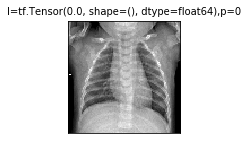

In [12]:
plot_images_labels_predict(X_train, Y_train, predictions, 5, 1)

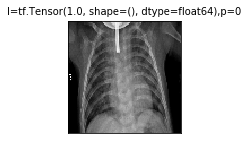

In [14]:
plot_images_labels_predict(X_train, Y_train, predictions, 2, 1)

In [15]:
import pandas as pd 
test_label_onearr = np.reshape(Y_test, [-1]).astype('int')
#predictions_onearr = np.reshape(predictions, [-1]).astype('int')
#print(len(predictions_onearr))
#print(len(test_label_onearr))
checkList = pd.DataFrame( {'label': test_label_onearr       # Column1 名稱: 欄位值集合 (這裡提供 Label 真實數值)
                          ,'prediction': np.argmax(predictions, axis=1)  # Column2 名稱: 欄位值集合 (這裡提供 AI 預測結果)
                          }
                        )

# 顯示對照表前 20 筆結果
print( checkList[0:20] )

    label  prediction
0       1           1
1       0           0
2       0           0
3       0           0
4       1           1
5       1           1
6       0           0
7       1           1
8       0           0
9       1           1
10      0           0
11      0           0
12      1           1
13      0           0
14      1           1
15      1           1
16      1           1
17      1           1
18      1           1
19      1           0


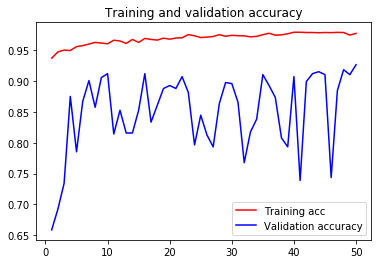

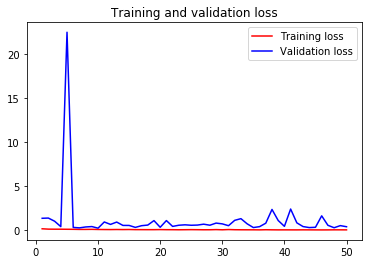

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
#plt.savefig('Model accuracy.png')

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
#plt.savefig('Model loss.png')

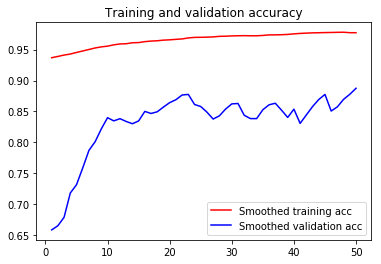

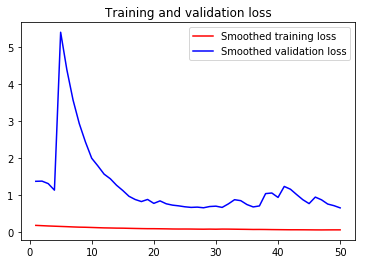

In [22]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot( epochs,
       smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot( epochs,
       smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot( epochs,
       smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot( epochs,
       smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
predict_label=np.argmax(predictions,axis=1)

In [21]:
import pandas as pd
pd.crosstab(test_label_onearr,predict_label,rownames=['label'],colnames=['predict'])

predict,0,1
label,,
0,204,30
1,16,374
